# Решение спитцеровского уравнения теплопроводности плазмы

## Неявная разностная схема с нелинейностью на нижнем слое

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^n_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^n_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right] + f^n_m
$$

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.pyplot import axes
#from celluloid import Camera

In [58]:
def qei(Te, Ti):
    if Te == 0:
        return 0.0
    else:
        return (Te - Ti) / Te ** 2

In [59]:
def k_12(y_m, y_m_1, alpha):
    return (y_m ** alpha + y_m_1 ** alpha) / 2

In [60]:
def u_init(x, To):
    u = np.zeros(x.size)
    for i in range(len(x)):
        if x[i] <= 1:
            u[i] = To
    return u

### Метод прогонки

#### Реализация метода

In [ ]:
def forward_denom(u, m, tau, h, Pm, alpha):
    return 1 + k_12(u[m], u[m + 1], alpha) * tau / h ** 2 + k_12(u[m - 1], u[m], alpha) * tau / h ** 2 * (1 - Pm)

def forward_P_numer(u, m, tau, h, alpha):
    return k_12(u[m], u[m + 1], alpha) * tau / h ** 2

def forward_Q_numer(u, m, n, tau, h, Qm, alpha, f):
    return k_12(u[m], u[m - 1], alpha) * tau / h ** 2 * Qm + f * tau

In [ ]:
def forward(u1, u2, n, tau, h, M, mode='electron'):
    # init params
    P = np.zeros(M)
    Q = np.zeros(M)
    u = u1[n, :] if mode == 'electron' else u2[n, :]
    alpha = 2.5 if mode == 'electron' else 1.5
    # Zero step
    P[0] = tau * k_12(u[0], u[1], alpha) / (h ** 2 + k_12(u[0], u[1], alpha) * tau)
    Q[0] = (u[0] + qei(u1[n, 0], u2[n, 0]) * tau) / (1 + k_12(u[0], u[1], alpha) * tau / h ** 2)
    # n = 1,..., M - 2
    for m in range(1, M - 1):
        denom = forward_denom(u, m, tau, h, P[m - 1], alpha)
        P_numer = forward_P_numer(u, m, tau, h, alpha)
        Q_numer = forward_Q_numer(u, m, n, tau, h, Q[m - 1], alpha, qei(u1[n, m], u2[n, m]))
        P[m] = P_numer / denom
        Q[m] = Q_numer / denom
    # Last step
    m = M - 1
    denom = 1 + u[m] ** alpha * tau / h ** 2 + k_12(u[m - 1], u[m], alpha) * tau / h ** 2 * (1 - P[m - 1])
    Q_numer = forward_Q_numer(u, m, n, tau, h, Q[m - 1], alpha, qei(u1[n, m], u2[n, m]))
    Q[m] = Q_numer / denom
    return P, Q

In [63]:
def backward(P, Q):
    M = P.size
    y = np.zeros(M)
    y[-1] = Q[-1]
    for m in range(M - 2, -1, -1):
        y[m] = P[m] * y[m + 1] + Q[m]
    return y

#### Применение метода

In [64]:
# Начальные значения
a = 0
b = 2
t_0 = 0
T = 0.01
To = 2

In [65]:
# Число узлов
N = 6000
M = 400

# Размер шага сетки
h = (b - a) / M
tau = (T - t_0) / N
print(f'{h=}, {tau=: .6f}')

print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h=0.005, tau= 0.000002
sigma =  0.0333


In [66]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [67]:
u1 = np.zeros((N + 1, M), dtype=np.double)
u1[0, :] = u_init(x, 2)

u2 = np.zeros((N + 1, M), dtype=np.double)
u2[0, :] = u_init(x, 2)

In [74]:
P = []
Q = []
for n in tqdm(range(3)):
    P_electron, Q_electron = forward(u1, u2, n, tau, h, M, mode='electron')
    u1[n + 1, :] = backward(P_electron, Q_electron)
    P_ion, Q_ion = forward(u1, u2, n, tau, h, M, mode='ion')
    u2[n + 1, :] = backward(P_ion, Q_ion)
    P.append(P_electron)
    Q.append(Q_electron)

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\aleks\AppData\Local\Temp\ipykernel_8768\445448729.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y_m ** alpha + y_m_1 ** alpha) / 2
C:\Users\aleks\AppData\Local\Temp\ipykernel_8768\172073463.py:15: RuntimeWarning: invalid value encountered in double_scalars
  P[m] = P_numer / denom
C:\Users\aleks\AppData\Local\Temp\ipykernel_8768\1800418094.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return k_12(u[m], u[m - 1], alpha) * tau / h ** 2 * Qm + f * tau


In [79]:
np.vstack(Q + P)

array([[ 1.45230245e+00,  3.31742405e-01,  7.50001150e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.40504735e+00,  1.30652526e-01,  3.34108875e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.31227661e+00,  9.76033837e-02, -2.36355731e-03, ...,
                    nan,             nan,             nan],
       [ 2.73848776e-01,  2.28425150e-01,  2.26079374e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.24016091e-02,  2.25666994e-03,  5.98111274e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.39832736e-02,  1.91469234e-04,  6.93144771e-11, ...,
                    nan,             nan,  0.00000000e+00]])

#### Визуализация

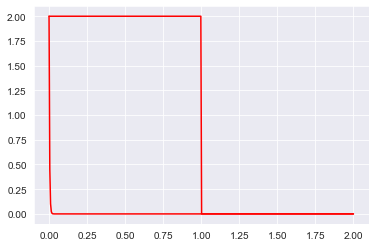

In [52]:
for i in range(2):
    plt.plot(x, u1[i, :], color="red")
    #ax.plot(x, u2[i, :], color="red")

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import axes
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(0, 1.5), ylim=(0, 2.5))

for i in range(0, N, 20):
    ax.plot(x, u1[i, :], color="blue")
    ax.plot(x, u2[i, :], color="red")
    camera.snap()
animation = camera.animate()
animation.save('oh_my.gif', writer = 'imagemagick')

### Метод потоковой прогонки